In [1]:
# User defined variables
my_state = 'MO' # State USPS abbreviation
state_name = 'Missouri'
# IA = 19; ID = 16; IL = 17; MN = 27; MO = 29; MT = 30; OR = 41;  WA = 53; WI = 55
state_fip = 'US%3A29' # Replace last 2 digits with your state's FIP code
my_path = 'data/' + my_state + '/' # leave this alone   
my_crs = 5070

In [2]:
#Import required packages
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import requests
from shapely.geometry import Point
from functools import reduce
import folium
import io
import os
import zipfile
from matplotlib import pyplot as plt
from io import StringIO
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import requests
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn import gaussian_process
from sklearn.neighbors import KDTree
from sklearn.model_selection import train_test_split
import skgstat as skg
import gstools as gs
from skgstat import models
from skgstat.util.likelihood import get_likelihood
import scipy
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix
from scipy.optimize import minimize
from scipy.spatial import cKDTree
from scipy.interpolate import NearestNDInterpolator
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import rasterio
from rasterio.transform import from_origin
import random
from rasterio.features import rasterize
import scipy.ndimage
from rasterio.transform import from_origin
from sklearn.neighbors import KNeighborsRegressor
from rasterio.mask import mask
import rasterio.plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
import glob
from affine import Affine

#Helper functions
def get_station_data(state):
    URL_BASE_2 = 'https://www.waterqualitydata.us/data/Station/search?'
    url_request_2 = f"{URL_BASE_2}countrycode=US&statecode={state}"
    response_2 = pd.read_csv(url_request_2)
    return response_2
def find_nearest(row, other_gdf):
    # Find the index of the nearest geometry
    nearest_idx = other_gdf.distance(row.geometry).idxmin()
    return other_gdf.loc[nearest_idx]

def add_nearest(gdf1, gdf2):
    nearest_neighbors = gdf1.apply(lambda row: find_nearest(row, gdf2), axis=1)
    # Add nearest neighbor information to the first GeoDataFrame
    gdf1['nearest_id'] = nearest_neighbors['station_id']
    gdf1['median'] = nearest_neighbors['median']
    parameter_added = gdf1
    return parameter_added

def get_data(state, characteristic, my_format):
    URL_BASE = 'https://www.waterqualitydata.us/data/Result/search?'
    url_request = f"{URL_BASE}countrycode=US&statecode={state}&characteristicName={characteristic}&mimeType={my_format}"
    response = pd.read_csv(url_request)
    return response

def interpolate(stations_w_data, filename, bandname="Interpolated_Band", max_grid_size=500):
    # Extract coordinates and values
    stations_w_data = stations_w_data.to_crs(my_crs)
    stations_w_data['x'] = stations_w_data.geometry.x
    stations_w_data['y'] = stations_w_data.geometry.y
    samples_df = stations_w_data[['x', 'y', 'median']]
    x_point = samples_df['x']
    y_point = samples_df['y']
    coords = np.column_stack((x_point, y_point))
    vals = samples_df['median']
    
    # Scatter plot of original data
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    art = ax.scatter(coords[:, 0], coords[:, 1], s=10, c=vals, cmap='plasma', vmin=0, vmax=vals.max())
    plt.colorbar(art)
    plt.title("Original Data Points")
    plt.show()
    
    # Adaptive grid sizing
    xmin, xmax = x_point.min(), x_point.max()
    ymin, ymax = y_point.min(), y_point.max()
    
    grid_x = min(max_grid_size, int((xmax - xmin) / 500))
    grid_y = min(max_grid_size, int((ymax - ymin) / 500))

    use_kriging = grid_x * grid_y <= 1e6
    
    try:
        if use_kriging:
            print("🔹 Attempting Ordinary Kriging interpolation...")
            V = skg.Variogram(coords, vals, model='exponential', maxlag='median', n_lags=30, normalize=False)
            ok = skg.OrdinaryKriging(V, min_points=1, max_points=8, mode='exact')
            xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
            field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
            s2 = ok.sigma.reshape(xx.shape)
            print("✅ Kriging completed successfully.")
        else:
            raise MemoryError  
    except (MemoryError, ValueError, np.linalg.LinAlgError):
        print("⚠️ Kriging failed, using Nearest Neighbor interpolation...")
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        knn = KNeighborsRegressor(n_neighbors=8, weights='distance', algorithm='kd_tree', n_jobs=-1)
        knn.fit(coords, vals)
        query_points = np.column_stack((xx.ravel(), yy.ravel()))
        field = knn.predict(query_points).reshape(xx.shape)
        s2 = np.zeros_like(field)
        print("✅ Nearest Neighbor interpolation completed.")

    # Fill missing values
    def fill_missing_values(field):
        mask = np.isnan(field)
        if np.all(mask):
            raise ValueError("All values are NaN; interpolation cannot be performed.")
        nearest_indices = scipy.ndimage.distance_transform_edt(mask, return_distances=False, return_indices=True)
        field[mask] = field[tuple(nearest_indices[i][mask] for i in range(field.ndim))]
        return field

    field = fill_missing_values(field)

    # Export interpolated raster
    nrows, ncols = field.shape
    xres = (xmax - xmin) / float(ncols)
    yres = (ymax - ymin) / float(nrows)
    arr = np.abs(field).astype(np.float32)

    # Ensure array is properly oriented
    arr = np.abs(field.T).astype(np.float32)  # Transpose to fix 90-degree rotation
    
    # Define transform with corrected Y-axis orientation
    transform = from_origin(xmin, ymax, xres, -yres)  # ymax ensures correct vertical alignment
    
    # Export raster
    with rasterio.open(filename, 'w', driver='GTiff',
                       height=arr.shape[0], width=arr.shape[1],  # Ensure correct height/width order
                       count=1, dtype=str(arr.dtype),
                       crs= my_crs,
                       transform=transform) as new_dataset:
        new_dataset.write(arr, 1)
        new_dataset.set_band_description(1, bandname)
    
    print(f"✅ Raster saved correctly: {filename}")
    
    # Plot corrected raster
    plt.figure(figsize=(10, 8))
    plt.imshow(arr, extent=[xmin, xmax, ymin, ymax], cmap='plasma', origin="lower")  # Corrected orientation
    plt.colorbar(label=bandname)
    plt.title("Interpolated Raster (Corrected Orientation)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

# This function requests and retrieves the AIS records from the USGS NAS database API
def nas_api_call(state):
    URL_BASE = 'http://nas.er.usgs.gov/api/v2/'
    url_request = f"{URL_BASE}/occurrence/search?state={state}"
    response = requests.get(url_request, timeout=None).json()
    results = pd.json_normalize(response, 'results')
    return results



def make_bg_data(geo_df):    
    species_columns = ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants']
    existing_columns = [col for col in species_columns if col in geo_df.columns]  
    random_points = []

    # Ensure input is in EPSG:5070
    if geo_df.crs and geo_df.crs != my_crs:
        geo_df = geo_df.to_crs(my_crs)

    for _, row in geo_df.iterrows():
        if not existing_columns or row[existing_columns].sum() == 0:  
            polygon = row.geometry
            if polygon.is_empty or not polygon.is_valid:
                random_points.append(None)
                continue

            minx, miny, maxx, maxy = polygon.bounds

            while True:
                random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
                if polygon.contains(random_point):
                    random_points.append(random_point)
                    break
        else:
            random_points.append(None)

    # Filter out None values before creating GeoDataFrame
    new_gdf = gpd.GeoDataFrame(geometry=[p for p in random_points if p is not None], crs="EPSG:5070")
    
    return new_gdf

# Function to clip point geometries by polygon geometries
def clip_points_by_polygon(points_gdf, polygon_gdf):
    # Ensure that both GeoDataFrames are in the same CRS
    if points_gdf.crs != polygon_gdf.crs:
        points_gdf = points_gdf.to_crs(polygon_gdf.crs)

    # Clip the points with the polygon(s)
    clipped_points = gpd.sjoin(points_gdf, polygon_gdf, how='inner')

    # Drop the geometry from polygon_gdf that was added during the join (if needed)
    clipped_points = clipped_points.drop(columns=polygon_gdf.columns.difference(['geometry']))

    return clipped_points

def sum_numeric_columns(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # Identify columns with six-digit string headers
    sum_columns = [col for col in gdf.columns if col.isdigit() and len(col) == 6]
    
    # Sum across these columns
    gdf["Native_Fish_Richness"] = gdf[sum_columns].sum(axis=1)
    
    # Create a new GeoDataFrame with only the sum and geometry
    return gdf[["Native_Fish_Richness", "geometry"]]

def spatial_join_with_nearest(poly_gdf: gpd.GeoDataFrame, point_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # Ensure both GeoDataFrames have the same CRS
    if poly_gdf.crs != point_gdf.crs:
        poly_gdf = poly_gdf.to_crs(point_gdf.crs)

    # Perform a nearest spatial join
    joined_gdf = gpd.sjoin_nearest(poly_gdf, point_gdf, how="left", distance_col="distance")

    return joined_gdf



def combine_geotiffs(input_files, output_file, state):
    band_data = []
    band_names = []
    
    # ✅ Use the first raster as a reference grid
    with rasterio.open(input_files[5]) as ref_src:
        ref_transform = ref_src.transform
        ref_crs = ref_src.crs
        ref_shape = (ref_src.height, ref_src.width)
        ref_bounds = ref_src.bounds
        
    state_crs = state.crs
    
    for file in input_files:
        with rasterio.open(file) as src:
            src_crs = src.crs
            src_data = []
            
            # ✅ Reproject RSD if CRS is different
            if src_crs != state_crs:
                transform, width, height = calculate_default_transform(
                    src_crs, state_crs, ref_shape[1], ref_shape[0], *ref_bounds
                )
                meta = src.meta.copy()
                meta.update({"crs": state_crs, "transform": transform, "width": width, "height": height})
                
                for i in range(1, src.count + 1):
                    data = np.empty((height, width), dtype=src.dtypes[i - 1])
                    reproject(
                        source=src.read(i),
                        destination=data,
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=state_crs,
                        resampling=Resampling.nearest
                    )
                    src_data.append(data)
            else:
                src_data = [src.read(i) for i in range(1, src.count + 1)]
            
            # ✅ Preserve band names
            for i in range(len(src_data)):
                band_name = src.descriptions[i] if src.descriptions and src.descriptions[i] else f"{file.split('/')[-1].split('.')[0]}_Band{i+1}"
                band_names.append(band_name)

            band_data.extend(src_data)

    meta.update(count=len(band_data))

    with rasterio.open(output_file, 'w', **meta) as dst:
        for i, data in enumerate(band_data):
            dst.write(data, i + 1)
            dst.set_band_description(i + 1, band_names[i])
    
    print(f"Successfully created {output_file} with {len(band_data)} bands.")

    # ✅ Check band names
    print("Band Names:")
    for i, name in enumerate(band_names, start=1):
        print(f"Band {i}: {name}")



In [3]:
# Download state boundaries shapefile
state_boundary_url = 'http://www2.census.gov/geo/tiger/TIGER2012/STATE/tl_2012_us_state.zip'
local_path = my_path
print('Downloading shapefile...')
r = requests.get(state_boundary_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)
# Get USGS monitoring stations from their API
my_stations = get_station_data(state = state_fip)
#Filter and convert to a Geodataframe
stations = my_stations[['MonitoringLocationIdentifier', 'LatitudeMeasure', 'LongitudeMeasure']].rename(columns = {'MonitoringLocationIdentifier': 'station_id',
                        'LatitudeMeasure' : 'latitude', 'LongitudeMeasure' : 'longitude'})  
stations_gdf = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.longitude, stations.latitude)).set_crs(4269, allow_override=True)
stations_gdf.to_file(my_path + 'usgs_monitoring_stations.shp') # Saving and importing saved files later allows you to import later without remaking variables
print('Station and State data saved')
stations_gdf = gpd.read_file(my_path + 'usgs_monitoring_stations.shp').set_crs(4269, allow_override=True)
state_boundary = gpd.read_file(my_path + 'tl_2012_us_state.shp').dropna().set_crs(4269, allow_override=True)

state = state_boundary[state_boundary['STUSPS'] == my_state]
my_state_stations = gpd.sjoin(stations_gdf, state, predicate="within")

Done
['tl_2012_us_state.dbf', 'tl_2012_us_state.prj', 'tl_2012_us_state.shp', 'tl_2012_us_state.shx']


C:\Users\leif.howard\AppData\Local\Temp\ipykernel_11620\1047313377.py:54: DtypeWarning: Columns (8,10,14,27,29,30,31,33,35) have mixed types. Specify dtype option on import or set low_memory=False.
  response_2 = pd.read_csv(url_request_2)


Station and State data saved


In [ ]:
# # Note this takes a while....
# ca = get_data(state = state_fip, my_format = 'csv', characteristic = 'Calcium')
# ca_resultsFile = pd.DataFrame(ca).dropna(subset=['ResultMeasureValue'])
# ca_resultsFile.ResultMeasureValue = pd.to_numeric(ca_resultsFile.ResultMeasureValue, errors='coerce')
# ca_fixed = ca_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
# # Change units for those that are equivalent to mg/L and make ug/L units consistent
# ca_clean_1 = ca_fixed.replace({'mg/l' : 'mg/L', 'mg/kg' : 'mg/L', 'mg/l CaCO3': 'mg/L', 'ug/l' : 'ug/L'} )
# # convert ug/L to mg/L
# ca_clean_1['value'] = ca_clean_1.apply(
#     lambda row: row['value'] / 1000 if row['unit'] == 'ug/L' else row['value'],
#     axis=1)
# #Change unit for converted values to mg/L
# ca_clean_2 = ca_clean_1.replace({'ug/L': 'mg/L'})
# #Get rid of other records not in mg/L
# my_ca = ca_clean_2[ca_clean_2['unit'] == 'mg/L']
# #Filter to reasonable values
# ca_fixed_2 = my_ca[my_ca['value'] < 300]
# ca_fixed_3 = ca_fixed_2[ca_fixed_2['value'] > 0]
# #Calculate summary stats by station_id
# ca_result = pd.DataFrame(ca_fixed_3.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
# stations_w_ca = pd.merge(my_state_stations, ca_result, on = 'station_id').dropna()
# ca_station_list = stations_w_ca['station_id'].tolist()
# stations_no_ca = my_state_stations[~my_state_stations['station_id'].isin(ca_station_list)]
# ca = add_nearest(stations_no_ca, stations_w_ca)
# my_ca_result = pd.concat([ca, stations_w_ca], axis = 0).drop(columns = {"nearest_id","latitude","longitude"})
# my_ca_result.to_file(my_path + 'usgs_ca.shp')

In [ ]:
# pH = get_data(state = state_fip, my_format = 'csv', characteristic = 'pH')
# pH_resultsFile =pd.DataFrame(pH).dropna(subset=['ResultMeasureValue'])
# pH_resultsFile.ResultMeasureValue = pd.to_numeric(pH_resultsFile.ResultMeasureValue, errors='coerce')
# pH_fixed = pH_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
# my_pH = pH_fixed.loc[(pH_fixed['unit'].isna()) | (pH_fixed['unit']== 'std units')]
# pH_result = pd.DataFrame(my_pH.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
# pH_fixed_2 = pH_result[pH_result['median'] < 14]
# pH_fixed_3 = pH_fixed_2[pH_fixed_2['median'] > 4]
# stations_w_pH = pd.merge(my_state_stations, pH_fixed_3, on = 'station_id').dropna()
# pH_station_list = stations_w_pH['station_id'].tolist()
# stations_no_pH = my_state_stations[~my_state_stations['station_id'].isin(pH_station_list)]
# pH = add_nearest(stations_no_pH, stations_w_pH)
# my_pH_result = pd.concat([pH, stations_w_pH], axis = 0).drop(columns = {"nearest_id", "latitude", "longitude"})
# my_pH_result.to_file(my_path + 'usgs_pH.shp')

In [ ]:
# di_N = get_data(state = state_fip, my_format = 'csv', characteristic = 'Nitrogen')
# di_N_resultsFile = pd.DataFrame(di_N).dropna(subset=['ResultMeasureValue'])
# di_N_resultsFile.ResultMeasureValue = pd.to_numeric(di_N_resultsFile.ResultMeasureValue, errors='coerce')
# di_N_fixed = di_N_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
# di_N_fixed.loc[(di_N_fixed['unit'] == 'ug/L') | 
#        (di_N_fixed['unit'] == 'ppb') | (di_N_fixed['unit'] == 'mg/g'), 'value'] /= 1000
# di_N_clean_1 = di_N_fixed.replace({'mg/l' : 'mg/L', 'mg/kg' : 'mg/L', 'ppb': 'mg/L', 'ug/L' : 'mg/L'})
# di_fixed_2 = di_N_clean_1[di_N_clean_1['unit'] == 'mg/L']
# di_fixed_3 = di_fixed_2[di_fixed_2['value']<= 500]
# di_fixed_4 = di_fixed_3[di_fixed_3['value'] > 0]
# di_N_result = pd.DataFrame(di_fixed_4.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
# stations_w_di_N = pd.merge(my_state_stations, di_N_result, on = 'station_id')#.to_crs(26915)
# di_N_station_list = stations_w_di_N['station_id'].tolist()
# stations_no_di_N = my_state_stations[~my_state_stations['station_id'].isin(di_N_station_list)]#.to_crs(26915)
# di_N = add_nearest(stations_no_di_N, stations_w_di_N)
# my_di_N_result = pd.concat([di_N, stations_w_di_N], axis = 0).drop(columns = {"nearest_id", "latitude","longitude"})
# my_di_N_result.to_file(my_path + 'usgs_N.shp')

In [ ]:
# do = get_data(state = state_fip, my_format = 'csv', characteristic = 'Oxygen')
# do_resultsFile = pd.DataFrame(do).dropna(subset=['ResultMeasureValue'])
# do_resultsFile.ResultMeasureValue = pd.to_numeric(do_resultsFile.ResultMeasureValue, errors='coerce')
# do_fixed = do_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
# do_fixed.loc[(do_fixed['unit'] == 'mg/L'), 'value'] *= 12.67
# do_clean_1 = do_fixed.replace({'mg/L' : '% saturatn', '% by vol' : '% saturatn'})
# do_fixed_2 = do_clean_1[do_clean_1['value']<= 1]
# do_fixed_3 = do_fixed_2[do_fixed_2['value']> 0]
# do_result = pd.DataFrame(do_fixed_3.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
# stations_w_do = pd.merge(my_state_stations, do_result, on = 'station_id')#.to_crs(26915)
# do_station_list = stations_w_do['station_id'].tolist()
# stations_no_do = my_state_stations[~my_state_stations['station_id'].isin(do_station_list)]#.to_crs(26915)
# do = add_nearest(stations_no_do, stations_w_do)
# my_do_result = pd.concat([do, stations_w_do], axis = 0).drop(columns = {"nearest_id", "latitude","longitude"})
# my_do_result.to_file(my_path + 'usgs_do.shp')

In [ ]:
# phos = get_data(state = state_fip, my_format = 'csv', characteristic = 'Phosphorus')
# phos_resultsFile = pd.DataFrame(phos).dropna(subset=['ResultMeasureValue'])
# phos_resultsFile.ResultMeasureValue = pd.to_numeric(phos_resultsFile.ResultMeasureValue, errors='coerce')
# phos_fixed = phos_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
# phos_fixed.loc[(phos_fixed['unit'] == 'ug/L') | 
#        (phos_fixed['unit'] == 'ppb') | (phos_fixed['unit'] == 'mg/g'), 'value'] /= 1000
# phos_clean_1 = phos_fixed.replace({'mg/l' : 'mg/L', 'mg/l PO4' : 'mg/L', 'mg/l as P' : 'mg/L', 'mg/kg' : 'mg/L', 'mg/kg as P' : 'mg/L',
#                                   'ug/L' : 'mg/L', 'ppb' : 'mg/L', 'mg/g' : 'mg/L'} )
# my_phos = phos_clean_1[phos_clean_1['unit'] == 'mg/L']
# phos_fixed_2 = my_phos[my_phos['value']<= 1]
# phos_result = pd.DataFrame(phos_fixed_2.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
# stations_w_phos = pd.merge(my_state_stations, phos_result, on = 'station_id')#.to_crs(4269)
# phos_station_list = stations_w_phos['station_id'].tolist()
# stations_no_phos = my_state_stations[~my_state_stations['station_id'].isin(phos_station_list)]#.to_crs(4269)
# phos = add_nearest(stations_no_phos, stations_w_phos)
# my_phos_result = pd.concat([phos, stations_w_phos], axis = 0).drop(columns = {"nearest_id", "latitude","longitude"})
# my_phos_result.to_file(my_path + 'usgs_phos.shp')

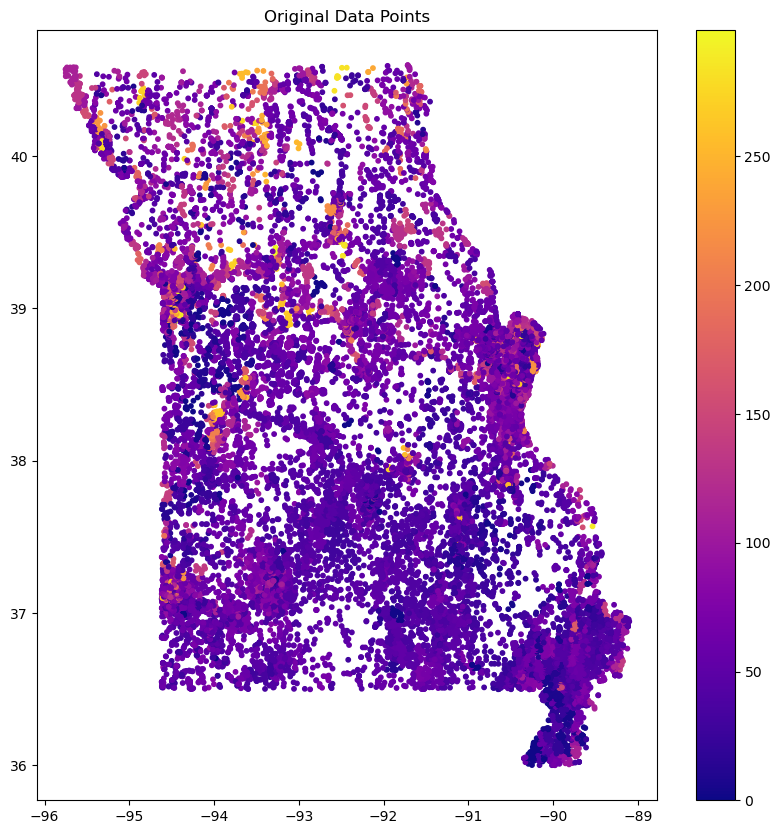

🔹 Attempting Ordinary Kriging interpolation...
✅ Kriging completed successfully.
✅ Raster saved correctly: ca.tif


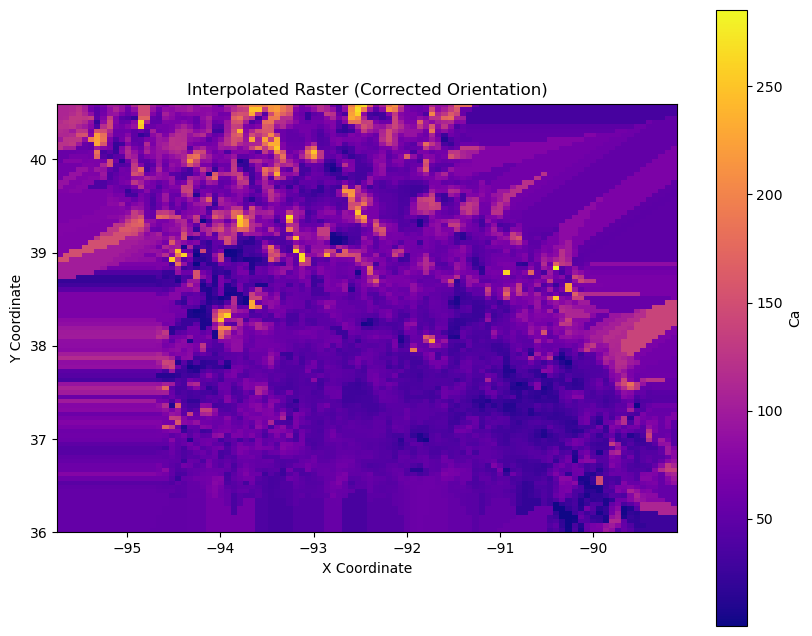

In [4]:
my_ca_result = gpd.read_file(my_path + 'usgs_ca.shp')
interpolate(my_ca_result, 'ca.tif', 'Ca')

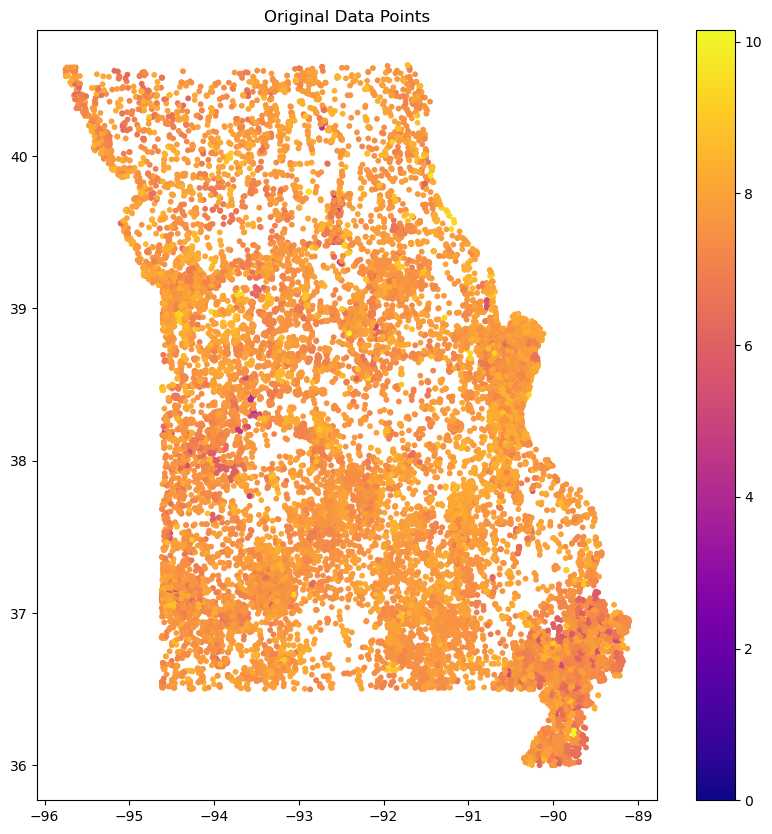

🔹 Attempting Ordinary Kriging interpolation...
✅ Kriging completed successfully.
✅ Raster saved correctly: pH.tif


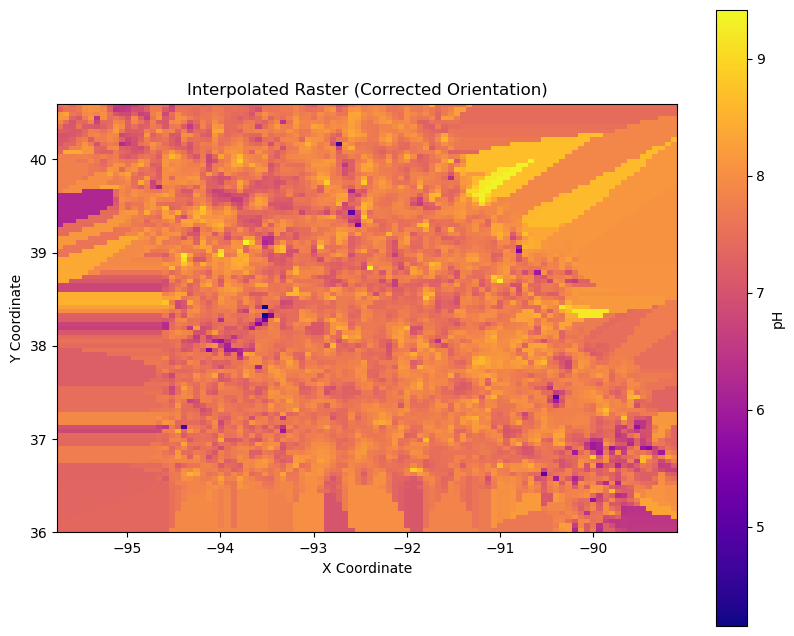

In [5]:
my_pH_result = gpd.read_file(my_path + 'usgs_pH.shp')
interpolate(my_pH_result, 'pH.tif', 'pH')

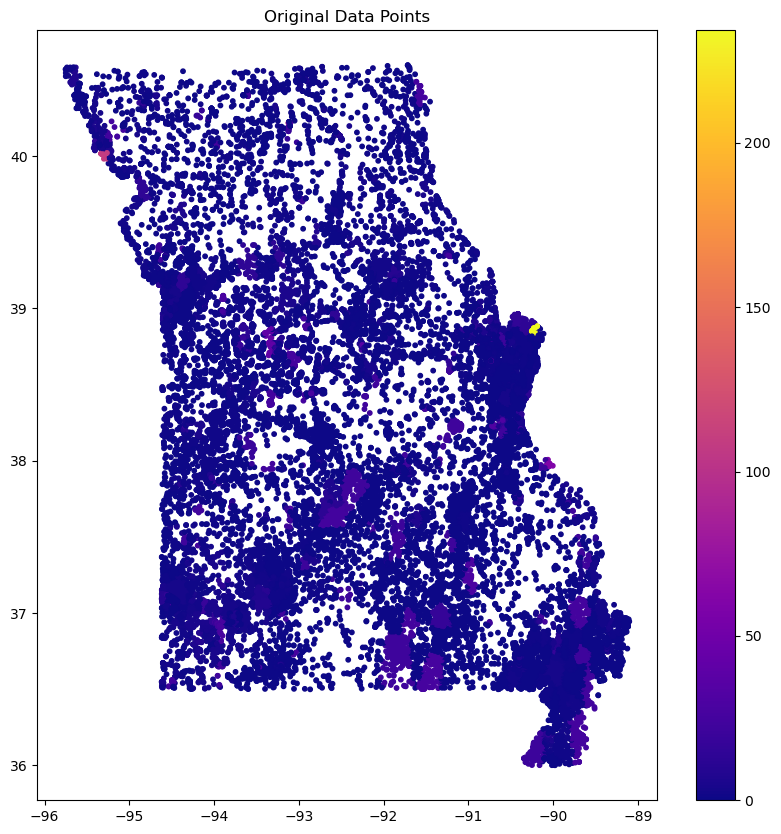

🔹 Attempting Ordinary Kriging interpolation...
✅ Kriging completed successfully.
✅ Raster saved correctly: di_N.tif


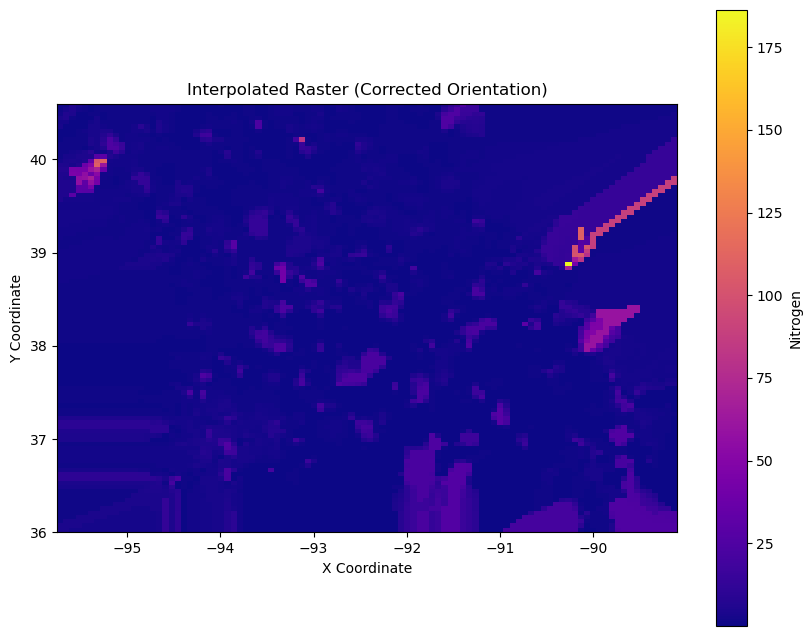

In [6]:
my_di_N_result = gpd.read_file(my_path + 'usgs_N.shp')
interpolate(my_di_N_result, 'di_N.tif', 'Nitrogen')

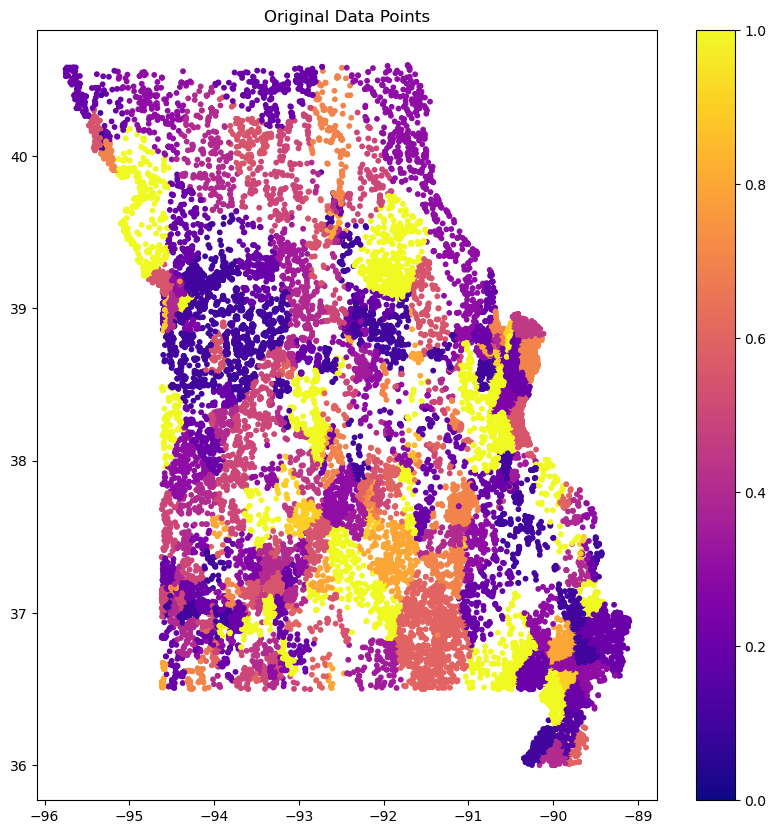

🔹 Attempting Ordinary Kriging interpolation...


In [ ]:
my_do_result = gpd.read_file(my_path + 'usgs_do.shp')
interpolate(my_do_result, 'do.tif', 'DO')

In [ ]:
my_phos_result = gpd.read_file(my_path + 'usgs_phos.shp')
interpolate(my_phos_result, 'phos.tif', 'Phos')

In [ ]:
# Start of Biological Variables
# Download waterbody shapefiles by state from NHD 
URL_BASE_NHD = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHD/State/Shape/'
NHD_url = f"{URL_BASE_NHD}NHD_H_{state_name}_State_Shape.zip"
local_path = my_path
print('Downloading shapefile...')
r = requests.get(NHD_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)


In [ ]:
# Import stream files
# Find all shapefiles that include "NHDFlowline_" in the filename
shapefiles = glob.glob(os.path.join(my_path + "/shape/", "*NHDFlowline_*.shp")) + glob.glob(os.path.join(my_path + "/shape/", "NHDFlowline.shp"))

# Ensure shapefiles were found
if not shapefiles:
    print("No shapefiles found matching the pattern.")

# Load all shapefiles into a list of GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shapefiles]

# Optionally, concatenate all shapefiles into a single GeoDataFrame
if gdfs:  # Only concatenate if the list is not empty
    stream_gdf = gpd.pd.concat(gdfs, ignore_index=True)
    print("Successfully merged shapefiles into a single GeoDataFrame.")
else:
    stream_gdf = None
    print("No valid shapefiles to merge.")

# Print summary
print(f"Imported {len(gdfs)} shapefiles")

In [ ]:
# Load the lake and river shapefiles produced earlier in this script for your state
lakes = gpd.read_file(my_path + "/shape/NHDWaterbody.shp").to_crs(4269)
rivers = gpd.read_file(my_path + "/shape/NHDArea.shp").to_crs(4269)
lakes_rivers = pd.concat([lakes, rivers])
lakes_rivers = lakes_rivers.set_crs(lakes.crs, allow_override=True)
my_lakes_rivers = lakes_rivers[lakes_rivers['areasqkm'] >= 0.25]
my_streams = stream_gdf[stream_gdf['lengthkm'] >= 10].to_crs(4269)

# Create 100-meter buffer so we are certain to join points to water and create raster later
my_lakes_rivers['buffer'] = my_lakes_rivers.buffer(0.01)
my_streams['buffer'] = my_streams.buffer(0.01)

my_water = pd.concat([my_lakes_rivers, my_streams])
my_water = my_water.set_crs(lakes_rivers.crs, allow_override=True)
# Drop the original geometry and setting the new geometry
buffered_water = my_water.drop(columns=['geometry']).set_geometry('buffer')
buffered_water = buffered_water.rename_geometry('geometry')
buffered_water.to_file(my_path + my_state + "_buffered_water.shp")

fig, ax = plt.subplots(figsize=(10, 8))
buffered_water.plot(ax=ax, color="blue", linewidth=0.5)

# Set title and labels
ax.set_title("Buffered Water", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [ ]:
nas_df = nas_api_call(my_state)
all_nas_df = pd.DataFrame(nas_df)
all_nas_data = all_nas_df[["speciesID", "commonName", "group", "state", "decimalLatitude", "decimalLongitude", "year", "status"]]
all_nas_data_fltr = all_nas_data[(all_nas_data['status'] == 'established')].dropna()
nas_gdf = gpd.GeoDataFrame(
    all_nas_data_fltr, geometry=gpd.points_from_xy(all_nas_data_fltr.decimalLongitude, all_nas_data_fltr.decimalLatitude))#.set_crs(my_crs)
nas_gdf.to_file(my_path + my_state + "_nas.shp") # Save file so you can start at the next block next time

In [ ]:
# Example usage:
nas_gdf = gpd.read_file(my_path + my_state + "_nas.shp")
nas_gdf = nas_gdf.set_crs(4269, allow_override=True)
for col in nas_gdf.select_dtypes(include=['int64']).columns:
    nas_gdf[col] = nas_gdf[col].astype('float64')

buffered_water = gpd.read_file(my_path + my_state + "_buffered_water.shp")

NAS_ais_obs_df = gpd.sjoin(nas_gdf, buffered_water, how="inner")
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Algae', 'Inv_Algae')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Plants', 'Inv_Plants')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Fishes', 'Inv_Fish')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Crustaceans-Cladocerans', 'Inv_Crustaceans')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Crustaceans-Cladocerans', 'Inv_Crustaceans')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Crustaceans-Amphipods', 'Inv_Crustaceans')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Mollusks-Bivalves', 'Inv_Mollusks')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Mollusks-Gastropods', 'Inv_Mollusks')
NAS_ais_df = NAS_ais_obs_df[['ObjectID', 'commonName', 'group']]

unique_commonnames = NAS_ais_df.groupby(['ObjectID', 'group'])['commonName'].nunique().reset_index()
pivot_df = unique_commonnames.pivot(index='ObjectID', columns='group', values='commonName').reset_index().fillna(0)
lakes_w_invasives = pd.merge(buffered_water, pivot_df, on = 'ObjectID', how = 'left')

# Define the required columns
species_columns = ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants', 'geometry']

# Add missing columns and fill with 0
for col in species_columns:
    if col not in lakes_w_invasives.columns:
        lakes_w_invasives[col] = 0  # Add missing column with default value 0

# Now safely select the columns and fill NaN values with 0
inv_rich = lakes_w_invasives[species_columns].fillna(0)
for col in inv_rich.select_dtypes(include=['int64']).columns:
    inv_rich[col] = inv_rich[col].astype('float64')

In [ ]:
def export_inv_richness(inv_rich_gdf, output_path):
    # Convert input data to EPSG:5070 BEFORE getting bounds
    inv_rich_gdf = inv_rich_gdf.to_crs(my_crs)
    data_columns = ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants']

    if inv_rich_gdf.empty:
        raise ValueError("Error: The input GeoDataFrame is empty!")

    # Get bounding box in CRS 5070
    xmin, ymin, xmax, ymax = inv_rich_gdf.total_bounds  
    pixel_size = 100  # 1000 meters per pixel

    # Ensure bounds are valid
    if xmin == xmax:
        xmin -= pixel_size
        xmax += pixel_size
    if ymin == ymax:
        ymin -= pixel_size
        ymax += pixel_size

    # Recalculate width and height
    width = max(1, int((xmax - xmin) / pixel_size))
    height = max(1, int((ymax - ymin) / pixel_size))

    # Correct transform in CRS 5070
    transform = Affine(pixel_size, 0, xmin, 0, -pixel_size, ymax)
    num_bands = len(data_columns) + 1  # Extra band for sum
    raster = np.zeros((num_bands, height, width), dtype=np.float32)

    # Debug: Check valid geometries
    valid_geom_count = inv_rich_gdf.geometry.notnull().sum()
    print(f"Valid geometries count: {valid_geom_count}")

    # Rasterize each data column
    for i, column in enumerate(data_columns):
        shapes = [(geom, value) for geom, value in zip(inv_rich_gdf.geometry, inv_rich_gdf[column]) if geom is not None and not np.isnan(value)]
        if not shapes:
            print(f"Skipping {column}: No valid geometries!")
            continue  # Skip empty bands
        raster_band = rasterize(
            shapes,
            out_shape=(height, width),
            transform=transform,
            fill=0,
            dtype='float32',
            default_value=1,  # Ensure full coverage of waterbody
            all_touched=True  # Ensures every pixel within the geometry gets a value
        )
        shapes = [(geom, value) for geom, value in zip(inv_rich_gdf.geometry, inv_rich_gdf[column])]
        raster_band = rasterize(
            shapes, out_shape=(height, width), transform=transform, fill=0, dtype='float32', all_touched=True
        )
        raster[i] = raster_band  # Keep original values
        print(f"Rasterized {column}: Min={raster_band.min()}, Max={raster_band.max()}, Non-zero pixels={np.count_nonzero(raster_band)}")

    # Compute the sum band
    raster[-1] = np.sum(raster[:-1], axis=0)
    print(f"Final Sum Band: Min={raster[-1].min()}, Max={raster[-1].max()}, Non-zero pixels={np.count_nonzero(raster[-1])}")

    # Save as a multi-band GeoTIFF in EPSG:5070
    with rasterio.open(
        output_path, 'w',
        driver='GTiff',
        height=height,
        width=width,
        count=num_bands,
        dtype=raster.dtype,
        crs=my_crs,
        transform=transform
    ) as dst:
        for band in range(num_bands):
            dst.write(raster[band], band + 1)
        band_names = data_columns + ["Inv_Richness"]
        for band, name in enumerate(band_names, start=1):
            dst.set_band_description(band, name)

    # Debug: Plot overlay of geometries on raster
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(raster[-1], cmap='viridis', extent=[xmin, xmax, ymin, ymax], origin="upper")
    gpd.GeoSeries(inv_rich_gdf.geometry).plot(ax=ax, facecolor="none", edgecolor="red")
    plt.title("Overlaying Geometries on Raster")
    plt.show()

    # Plot bands
    fig, axes = plt.subplots(1, num_bands, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(raster[i], cmap='viridis')
        ax.set_title(band_names[i])
        ax.axis('off')
    plt.show()

    print(f"Raster file saved as '{output_path}' in CRS {my_crs} with band names: {band_names}")

In [ ]:
export_inv_richness(inv_rich, my_path + my_state + '_inv_richness.tif')

In [ ]:
# Create your background data input and export
bg_gdf = make_bg_data(inv_rich)  # Generate random points only for selected polygons
bg_gdf.to_file(my_path + my_state +'_bg.shp')

In [ ]:
# Export Native Fish 
# Download data from USGS native fish presence/absence dataset
URL_BASE = "https://www.sciencebase.gov/catalog/file/get/6086df60d34eadd49d31b04a?f=__disk__ad%2F21%2Ffc%2Fad21fc677379f4e45caa4bd506ca1c587d5f01f7"

response = requests.get(URL_BASE)

if response.status_code == 200:
    # Convert response content to DataFrame
    csv_data = StringIO(response.text)
    fish_df = pd.read_csv(csv_data)

    # Convert DataFrame to GeoDataFrame
    fish_gdf = gpd.GeoDataFrame(
        fish_df, geometry=gpd.points_from_xy(fish_df.longitude, fish_df.latitude)
    ).set_crs(4269).to_crs(5070)
else:
    print(f"Error: Failed to download data (status code {response.status_code})")


state_boundary = gpd.read_file(my_path + 'tl_2012_us_state.shp').dropna().to_crs(5070)
state = state_boundary[state_boundary['STUSPS'] == my_state]
# Clip the points by the polygon
clipped_native_fish = clip_points_by_polygon(fish_gdf, state)
# Save to shapefile
clipped_native_fish.to_file(my_path + my_state + '_native_fish_gdf.shp')
#clipped_native_fish = gpd.read_file(my_path + my_state + '_native_fish_gdf.shp')
native_fish_gdf = sum_numeric_columns(clipped_native_fish)#.to_crs(4269)
water_w_native_fish = spatial_join_with_nearest(buffered_water, native_fish_gdf)
for col in water_w_native_fish.select_dtypes(include=['int64']).columns:
    water_w_native_fish[col] = water_w_native_fish[col].astype('float64')


In [ ]:
def export_native_raster(joined_gdf: gpd.GeoDataFrame, resolution: int = 100):
    bounds = joined_gdf.total_bounds
    transform = rasterio.transform.from_origin(bounds[0], bounds[3], resolution, resolution)
    out_shape = (
        int(np.ceil((bounds[3] - bounds[1]) / resolution)),  
        int(np.ceil((bounds[2] - bounds[0]) / resolution))
    )
    
    column_name = "Native_Fish_Richness"  # Change this to dynamically select the column if needed
    raster = rasterize(
        [(geom, value) for geom, value in zip(joined_gdf.geometry, joined_gdf[column_name])],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=rasterio.float32
    )
    
    output_filename = f"{my_path}{my_state}_{column_name}_richness.tif"
    
    with rasterio.open(
        output_filename, "w",
        driver="GTiff",
        height=out_shape[0],
        width=out_shape[1],
        count=1,
        dtype=rasterio.float32,
        crs=my_crs,
        transform=transform
    ) as dst:
        dst.write(raster, 1)
        dst.set_band_description(1, column_name)  # Set band name
    
    # Plot the raster
    plt.figure(figsize=(10, 6))
    plt.imshow(raster, cmap='viridis', extent=[bounds[0], bounds[2], bounds[1], bounds[3]])
    plt.colorbar(label=f'{column_name} Richness')
    plt.title('Rasterized GeoDataFrame')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


In [ ]:
export_native_raster(water_w_native_fish)

In [ ]:
# Define input files
input_files = [
    my_path + "ca.tif", my_path + "pH.tif", my_path + "di_N.tif", my_path + "do.tif", my_path + "phos.tif", 
    my_path + my_state + "_rsd.tif", my_path + my_state + "_inv_richness.tif", 
    my_path + my_state + "_Native_Fish_Richness.tif"
]


# Step 2: Combine aligned rasters into a multi-band GeoTIFF
output_file = my_path + my_state + "_combined.tif"
combine_geotiffs(input_files, output_file, state)

print(f"✅ Multi-band raster saved as {output_file}")